# Imports

Import necessary libraries and modules including:
| Libraries | Version | Channel |
| ----------- | ----------- | ----------- |
| Matplotlib | 3.9.1 | conda-forge |
| NumPy | 2.2.2 | conda-forge |
| Matplotlib | 3.9.1 | conda-forge |
| Pandas | 2.2.3 | conda-forge |
| Pillow | 9.4.0 | conda-forge |
| Pytorch | 2.5.1 | conda-forge |
| Seaborn | 0.13.2 | conda-forge |
| Sklearn | 1.6.1 | conda-forge |

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchvision.transforms as transforms

from PIL import Image
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR


# Variables

For the sake of simpleness, the essentail constants are listed down below.

In [34]:
# Torch seed (for reproducibility purpose)
SEED = 33

In [35]:
# Dataset paths
base_dir = "faces_dataset"

dataset_dir = os.path.join(base_dir, "dataset", "dataset", "test")

test_dir_real = os.path.join(dataset_dir, "0")
test_dir_fake = os.path.join(dataset_dir, "1")

In [36]:
# Training varaibles
BATCH_SIZE = 64 # Number of images per batch
NUM_WORKERS = 12 # Number of CPU cores used for dataloader

# Image information
image_info = {
    # Both width and height are usually equal
    "width": 256,
    "height": 256
}

# Training data labels map
labels_map = {
    0: "Human",
    1: "AI"
}

In [37]:
# Display variables
display_figure_info = {
    "width": 12,
    "height": 12,
    "row": 3,
    "column": 3
}

In [38]:
# Current model
def get_current_model_path(new_model=False):
    count = 1

    while (True):
        if (os.path.isfile("../../trained_models/image_faces_convnext_model_" + f"{count}" + ".pth") == False):
            if (new_model):
                return "../../trained_models/image_faces_convnext_model_" + f"{count}" + ".pth"
            else:
                return "../../trained_models/image_faces_convnext_model_" + f"{count - 1}" + ".pth"
        else:
            count += 1

# Data Preprocessing

TODO: methods

In [39]:
torch.cuda.empty_cache() # Free CUDA cache memory
torch.manual_seed(SEED) # Assign Pytorch seed for reproducibility

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Initiate a CUDA device instance, if exists

In [40]:
test_fake_faces_path = [os.path.join(test_dir_fake, file) for file in os.listdir(test_dir_fake) if file.endswith(".jpg")]
test_real_faces_path = [os.path.join(test_dir_real, file) for file in os.listdir(test_dir_real) if file.endswith(".jpg")]

In [41]:
print(len(test_fake_faces_path))
print(len(test_real_faces_path))

10190
14000


In [42]:
test_path = test_fake_faces_path + test_real_faces_path
test_path_df = pd.DataFrame(test_path, columns=["id"])

In [43]:
test_path_df

,id
0,faces_dataset/dataset/dataset/test/1/ff3b28971...
1,faces_dataset/dataset/dataset/test/1/5859b50b3...
2,faces_dataset/dataset/dataset/test/1/fbd6c2802...
3,faces_dataset/dataset/dataset/test/1/3acd04a61...
4,faces_dataset/dataset/dataset/test/1/cc15efdd6...
...,...
24185,faces_dataset/dataset/dataset/test/0/58585.jpg
24186,faces_dataset/dataset/dataset/test/0/22573.jpg
24187,faces_dataset/dataset/dataset/test/0/69924.jpg
24188,faces_dataset/dataset/dataset/test/0/24491.jpg


In [44]:
# Get training labels
test_labels = []

for i in test_fake_faces_path:
    test_labels.append(1)
for i in test_real_faces_path:
    test_labels.append(0)

# Convert list to Pandas dataframe
test_labels_df = pd.DataFrame({'label': test_labels})

# # Get testing labels
# val_labels = []

# for i in train_fake_faces_path:
#     val_labels.append(1)
# for i in train_real_faces_path:
#     val_labels.append(0)

# # Convert list to Pandas dataframe
# val_labels_df = pd.DataFrame({'label':val_labels})

In [45]:
test_labels_df = pd.concat([test_path_df, test_labels_df], axis=1)

In [46]:
test_labels_df

,id,label
0,faces_dataset/dataset/dataset/test/1/ff3b28971...,1
1,faces_dataset/dataset/dataset/test/1/5859b50b3...,1
2,faces_dataset/dataset/dataset/test/1/fbd6c2802...,1
3,faces_dataset/dataset/dataset/test/1/3acd04a61...,1
4,faces_dataset/dataset/dataset/test/1/cc15efdd6...,1
...,...,...
24185,faces_dataset/dataset/dataset/test/0/58585.jpg,0
24186,faces_dataset/dataset/dataset/test/0/22573.jpg,0
24187,faces_dataset/dataset/dataset/test/0/69924.jpg,0
24188,faces_dataset/dataset/dataset/test/0/24491.jpg,0


In [47]:
#  Evaluate the training labels
count = 0

for i in range(len(test_labels)):
    if (test_labels[i] == 1):
        count = count+1

print(test_labels)
print("Number of total labels:", len(test_labels))
print("Number of fake faces samples:", count)
print("Number of real faces samples:", len(test_labels) - count)


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [48]:
# Training augmentations
train_transforms = transforms.Compose([
    transforms.Resize(232),  # Resize to match ConvNeXt preprocessing
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Validation and Test transforms
val_test_transforms = transforms.Compose([
    transforms.Resize(232),  # Resize to 232 as per ConvNeXt documentation
    transforms.CenterCrop(224), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [49]:
# Dataset class for training and validation
class CustomTrainImageDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.dataframe.iloc[idx, 0])
        image = Image.open(img_name).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        label = self.dataframe.iloc[idx, 1]
        return image, label

# Dataset class for inference (validation and test)
class CustomTestImageDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, os.path.basename(img_path)

In [50]:
# Create datasets
# For testing, create a list of file paths (id)
test_file_list = test_labels_df["id"]
test_dataset = CustomTestImageDataset(file_list=test_file_list, transform=val_test_transforms)

# Create DataLoaders
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [51]:
# Display datasets' information
print(f"Test dataset size: {len(test_dataset)}")

Test dataset size: 24190


# Evaluating the Model

Evaluate and visualize the trained model's performance using validation set.

In [52]:
current_model_path = get_current_model_path()

In [53]:
# Load pretrained ConvNeXt Base model
model = models.convnext_base(weights="DEFAULT")

# Freeze the backbone
for param in model.features.parameters():
    param.requires_grad = False

# Replace the classifier head with a custom one
model.classifier = nn.Sequential(
    nn.AvgPool2d(kernel_size=3, padding=1, stride=3),  
    nn.Flatten(),                 
    nn.Linear(1024, 512),         
    nn.ReLU(),                    
    nn.Dropout(0.4),  
    nn.Linear(512, 2),         
)

# Load model
model.load_state_dict(torch.load(current_model_path)) # load the trained model
model = model.to(device)

In [54]:
correct = 0 # number of correct predictions
total = 0 # number of total predictions

In [55]:
def load_image(image_path):
    image = Image.open(image_path)
    image = val_test_transforms(image)
    image = image.unsqueeze(0)

    return image.to(device)

In [59]:
test_image_paths = [
    "/home/pooh/coding/AI_vs_human_generated_content_models/src/image/faces_dataset/dataset/dataset/test/0/00000.jpg",
    "/home/pooh/coding/AI_vs_human_generated_content_models/src/image/faces_dataset/dataset/dataset/test/0/00008.jpg",
    "/home/pooh/coding/AI_vs_human_generated_content_models/src/image/faces_dataset/dataset/dataset/test/0/00012.jpg",
    "/home/pooh/coding/AI_vs_human_generated_content_models/src/image/faces_dataset/dataset/dataset/test/0/00018.jpg",
    "/home/pooh/coding/AI_vs_human_generated_content_models/src/image/faces_dataset/dataset/dataset/test/1/0a0d9a2231dd4b0f9a28c4f4ac78470dc6409dc0.jpg",
    "/home/pooh/coding/AI_vs_human_generated_content_models/src/image/faces_dataset/dataset/dataset/test/1/0a5af1379a6b932e643d9d5425fb623b87b536066d1ac5b9a70275fcaea6eea8.jpg",
    "/home/pooh/coding/AI_vs_human_generated_content_models/src/image/faces_dataset/dataset/dataset/test/1/0a5e9e47b708863223f4b311577bed17e3ff2a25fcb9505874e2866dfaa2af61.jpg",
    "/home/pooh/coding/AI_vs_human_generated_content_models/src/image/faces_dataset/dataset/dataset/test/1/0a6c04db17d4cdcce137708101916be457b01c071f47c3aa985c190b6bf05abb.jpg",
    "/home/pooh/coding/AI_vs_human_generated_content_models/src/image/faces_dataset/dataset/dataset/test/1/0a9ebf06a0f94453cf741f6724677968804eb1d2a2466bfb50eca9491869f544.jpg",
]

images = [load_image(img) for img in test_image_paths]

In [60]:
model.eval()
prediction_labels = []

with torch.no_grad():
    for img in images:
        outputs = model(img)
        _, predicted = torch.max(outputs, 1)
        prediction_labels.append(predicted.item())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9306722..2.3785625].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.535425].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5702832].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.4831376].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9980307..2.50056

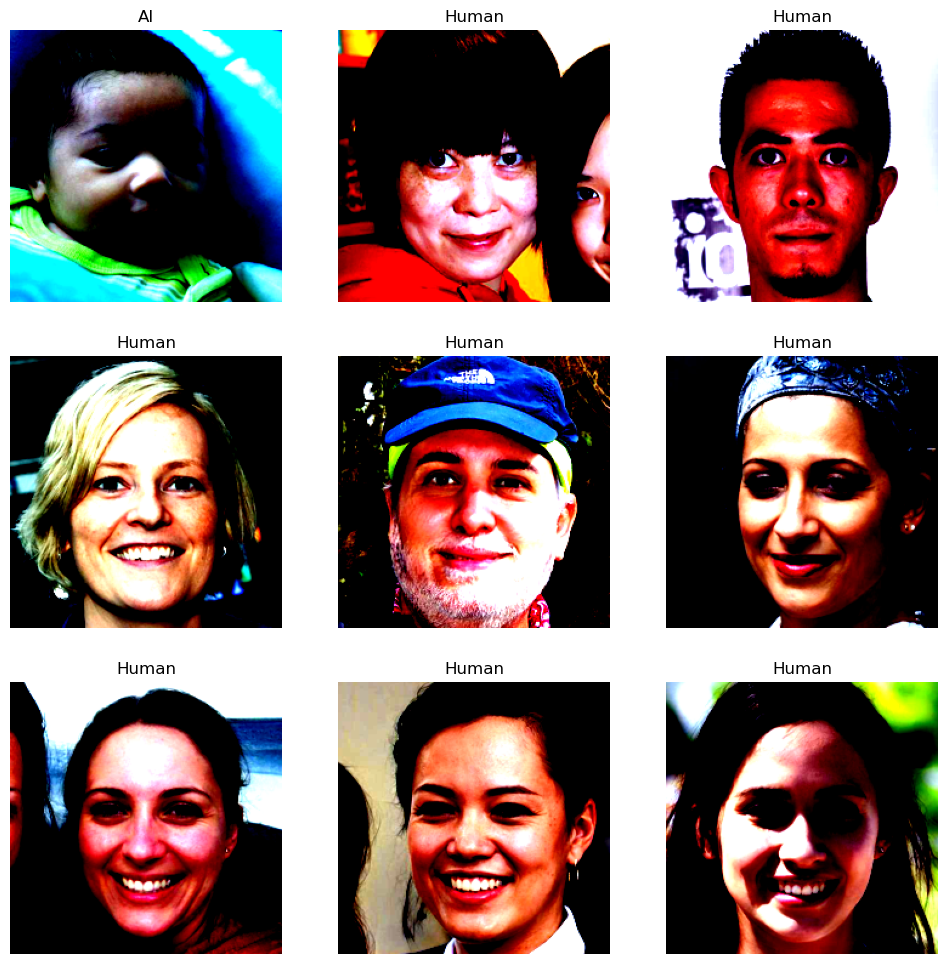

In [61]:
figure = plt.figure(figsize=(display_figure_info["width"], display_figure_info["height"]))

for i in range(1, display_figure_info["row"] * display_figure_info["column"] + 1):
    image_index = (i - 1) % len(images)
    image = images[image_index].cpu().squeeze(0).permute(1, 2, 0)
    label = prediction_labels[image_index]

    figure.add_subplot(display_figure_info["row"], display_figure_info["column"], i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(image)

plt.show()

Classification Report:
               precision    recall  f1-score   support

       Human       0.95      0.93      0.94    240768
          AI       0.95      0.96      0.95    298870

    accuracy                           0.95    539638
   macro avg       0.95      0.95      0.95    539638
weighted avg       0.95      0.95      0.95    539638



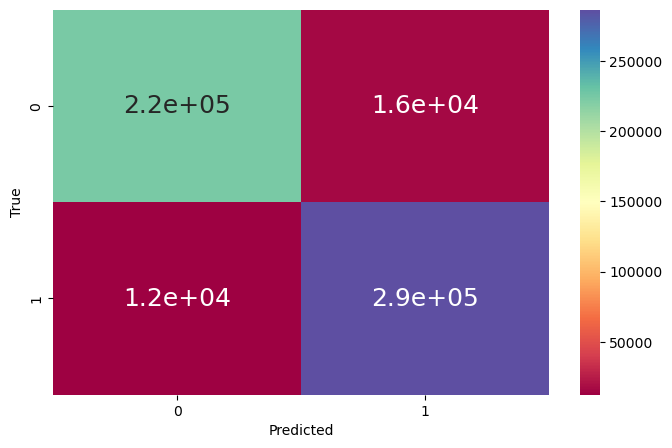

In [ ]:
# Classification report
train_report = classification_report(all_labels, all_preds, target_names=[labels_map[i] for i in labels_map])

print("Classification Report:\n", train_report)

# Confusion matrix
cf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 5))
sns.heatmap(cf_matrix, annot=True, annot_kws={"size": 18}, cmap="Spectral")
plt.ylabel('True')
plt.xlabel('Predicted')

count = 1

while (True):
    if (os.path.isfile("../../trained_models/image_faces_convnext_model_" + f"{count}" + ".pth") == False):
        plt.savefig("../../src/image/graphs/image_faces_convnext_model_" + f"{count - 1}" + "_classification_report.png") # Save the graph
        break
    else:
        count += 1

plt.show()